In [29]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import KFold, cross_val_score,  StratifiedKFold, GridSearchCV
from tqdm import tqdm
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import Normalizer
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# __1. Tree-Based Methods__

## __a. Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks. The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.__

In [30]:
# path
aps_train_path = '../data/aps_failure_training_set.csv'
aps_test_path = '../data/aps_failure_test_set.csv'

In [31]:
aps_train = pd.read_csv(aps_train_path, skiprows=20, na_values = 'na') #header=None
aps_test = pd.read_csv(aps_test_path, skiprows=20, na_values = 'na')

aps_total = pd.concat([aps_train, aps_test])

In [32]:
aps_train

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,neg,153002,NaN,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,neg,2286,NaN,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,neg,112,0.0,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,neg,80292,NaN,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [33]:
aps_train.shape

(60000, 171)

In [34]:
aps_test

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0.0,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,neg,82,0.0,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,neg,66002,2.0,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,neg,59816,NaN,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,neg,1814,NaN,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,neg,81852,NaN,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,neg,18,0.0,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,neg,79636,NaN,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,neg,110,NaN,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


In [35]:
aps_test.shape


(16000, 171)

### __(b) Data Preparation__

### __This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea.__

In [36]:
aps_X = aps_train.drop(columns = 'class')
aps_Y = aps_train['class']
aps_test_X = aps_test.drop(columns = 'class')
aps_test_Y = aps_test['class']
print("Shape of train_X :",aps_X.shape ,"\nShape of test_X : ", aps_test_X.shape )

Shape of train_X : (60000, 170) 
Shape of test_X :  (16000, 170)


### __i. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.__

There are many ways to handle missing values. Some of them are
- Remove samples that contain a missing value
- Replace missing values with a constant value that has meaning within the domain Ex: Categorical Features
- Replace missing values with a feature value from another randomly selected observation
- Replace missing values with a statistics such as mean, median or mode value of the feature/column.
- Expectation Maximization

In [37]:
aps_train_X = aps_train.iloc[:, 1:]
aps_train_Y = aps_train.iloc[:, 0]
aps_test_X = aps_test.iloc[:, 1:]
aps_test_Y = aps_test.iloc[:, 0]

__I am using Mean Data Imputation to replace missing value__

In [38]:
aps_train_X

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,153002,NaN,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,2564.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,2286,NaN,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,112,0.0,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,80292,NaN,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [39]:
imputer_mean = SimpleImputer(missing_values=np.nan)

# By default mean is used for the strategy
aps_train_X = pd.DataFrame(imputer_mean.fit_transform(aps_train_X), columns=aps_train.columns[1:])
aps_test_X = pd.DataFrame(imputer_mean.fit_transform(aps_test_X), columns=aps_test.columns[1:])

In [40]:
aps_train_X

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,153002.0,0.713189,6.640000e+02,186.000000,0.0,0.0,0.0,0.0,0.0,2564.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,2286.0,0.713189,2.130707e+09,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,112.0,0.000000,2.130706e+09,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,80292.0,0.713189,2.130706e+09,494.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [41]:
aps_test_X

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60.0,0.000000,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,82.0,0.000000,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,66002.0,2.000000,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,59816.0,0.772065,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,1814.0,0.772065,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,81852.0,0.772065,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,18.0,0.000000,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,79636.0,0.772065,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,110.0,0.772065,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


Not combining training and testing data as to keep testing data away from influence of training data

__2) Using Iterative Imputation - Sklearn IterativeImputer was inspired by the R MICE package but differs from it by returning a single imputation instead of multiple imputations.__

In [42]:
# imputer = IterativeImputer(estimator = BayesianRidge(), n_nearest_features=None)

# # fit and transform the dataset
# aps_X_imps = imputer.fit_transform(aps_X)
# aps_test_X_imps = imputer.fit_transform(aps_test_X)

In [43]:
# aps_X_imp = pd.DataFrame(aps_X_imps, columns= aps_X.columns)
# aps_X_imp

In [44]:
# aps_test_X_imp = pd.DataFrame(aps_test_X_imps, columns= aps_test_X.columns)
# aps_test_X_imp

__Observation : IterativeImputer took more time to process than Simple Imputer__

### __ii. For each of the 170 features, calculate the coefficient of variation CV =  s/m, where s is sample standard deviation and m is sample mean.__

In [45]:
# A coefficient of variation is a way to measure how spread out values are in a dataset relative to the mean.
cv_aps = aps_train_X.apply(lambda column : np.abs(column.std() / column.mean()), axis=0)
cv_aps

aa_000      2.450938
ab_000      2.328400
ac_000      2.169767
ad_000    183.847620
ae_000     23.190937
             ...    
ee_007      4.962483
ee_008      3.222010
ee_009      5.626979
ef_000     47.124953
eg_000     40.553250
Length: 170, dtype: float64

### __iii. Plot a correlation matrix for your features using pandas or any other tool__

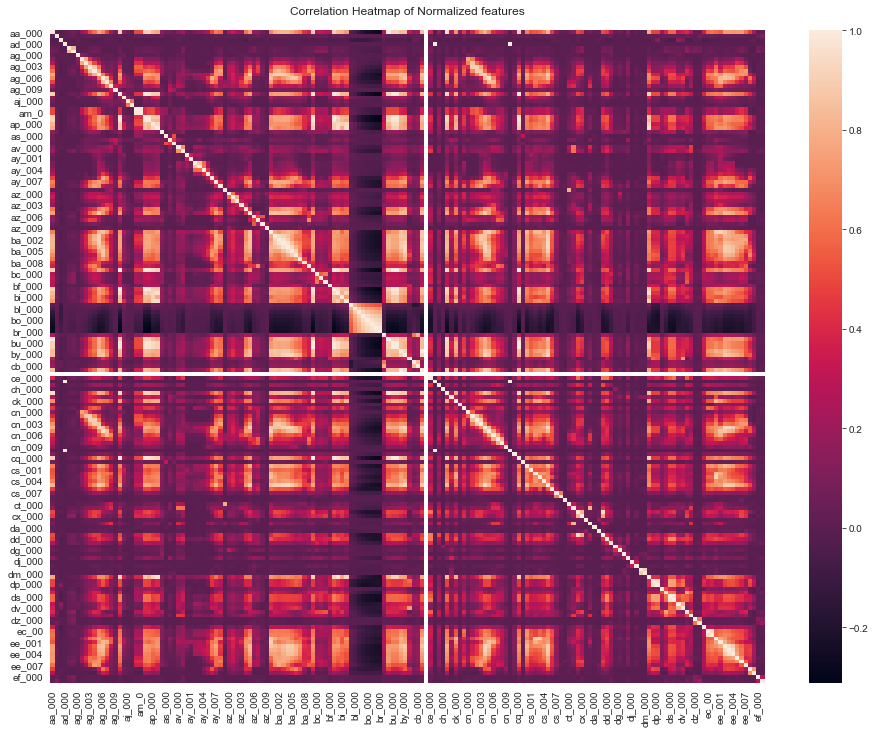

In [46]:
plt.close()
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(aps_train_X.corr())
heatmap.set_title('Correlation Heatmap of Normalized features', fontdict={'fontsize':12}, pad=16);
plt.show()

### __iv. Pick $\lfloor\sqrt{170}\rfloor$ features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.__

In [47]:
# Select features with best CV
no_of_features = int(np.floor(np.sqrt(170)))
best_feat = cv_aps.sort_values(ascending=False)[:no_of_features]
selected_features = best_feat.index.to_list()
best_feat

cs_009    235.277605
cf_000    184.233092
co_000    183.949017
ad_000    183.847620
dh_000    114.984991
dj_000    109.647285
ag_000     91.878565
as_000     86.416904
ay_009     83.786063
az_009     76.967978
ak_000     74.526688
au_000     68.160554
ch_000     58.268229
dtype: float64

In [48]:
best_df = aps_train_X[selected_features]
best_df['class'] = aps_train_Y
best_df

,cs_009,cf_000,co_000,ad_000,dh_000,dj_000,ag_000,as_000,ay_009,az_009,ak_000,au_000,ch_000,class
0,0.0,2.000000,220.000000,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,neg
1,0.0,190221.810984,190515.566938,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000443,neg
2,0.0,0.000000,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,neg
3,0.0,2.000000,2.000000,66.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,neg
4,0.0,0.000000,202.000000,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.000000,224.000000,186.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,neg
59996,0.0,2.000000,0.000000,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,neg
59997,0.0,2.000000,0.000000,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,neg
59998,0.0,2.000000,580.000000,494.000000,190.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,neg


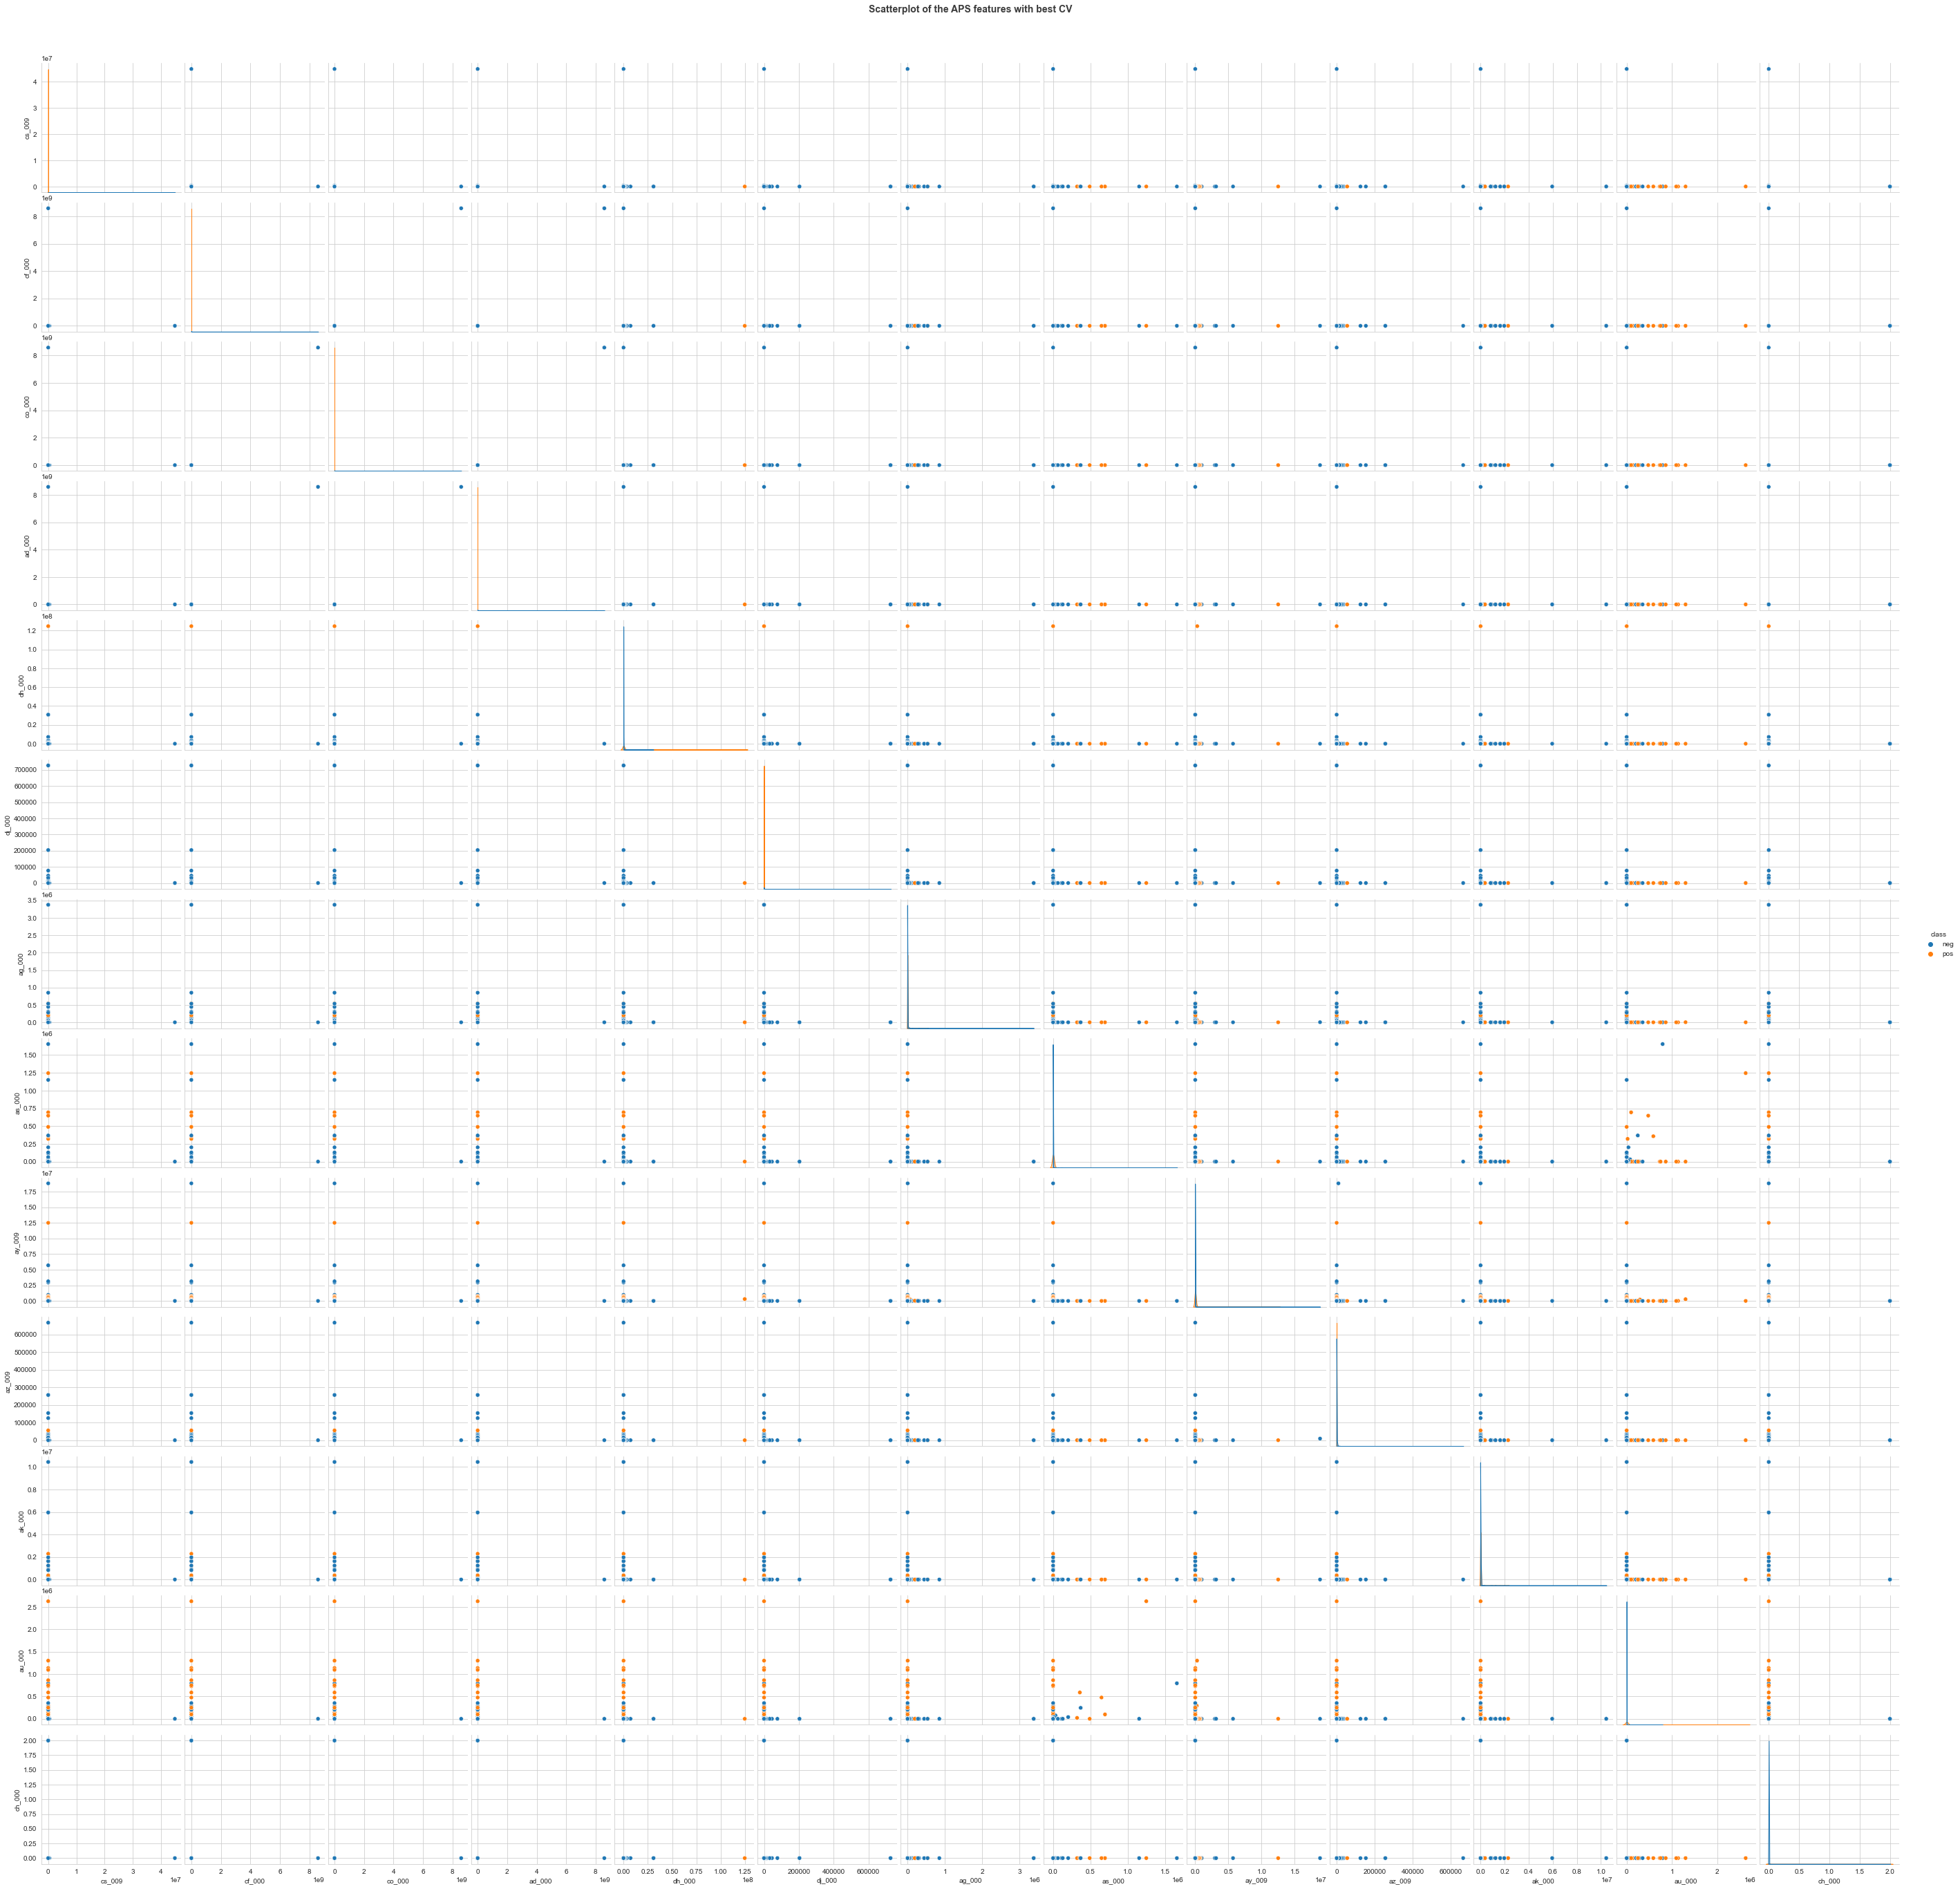

In [49]:
plt.close()
sns.set_style("whitegrid")
splot = sns.pairplot(best_df, hue='class', height=3, diag_kind="kde");
splot.fig.subplots_adjust(top=0.95)
splot.fig.suptitle('Scatterplot of the APS features with best CV', fontsize=14, alpha = 0.9, weight = 'bold')
plt.show()

#### __Can you draw conclusions about significance of those features, just by the scatter plots?__

No, It's hard to make conclusions about significance of those features, just by eyeballing the scatter plots.

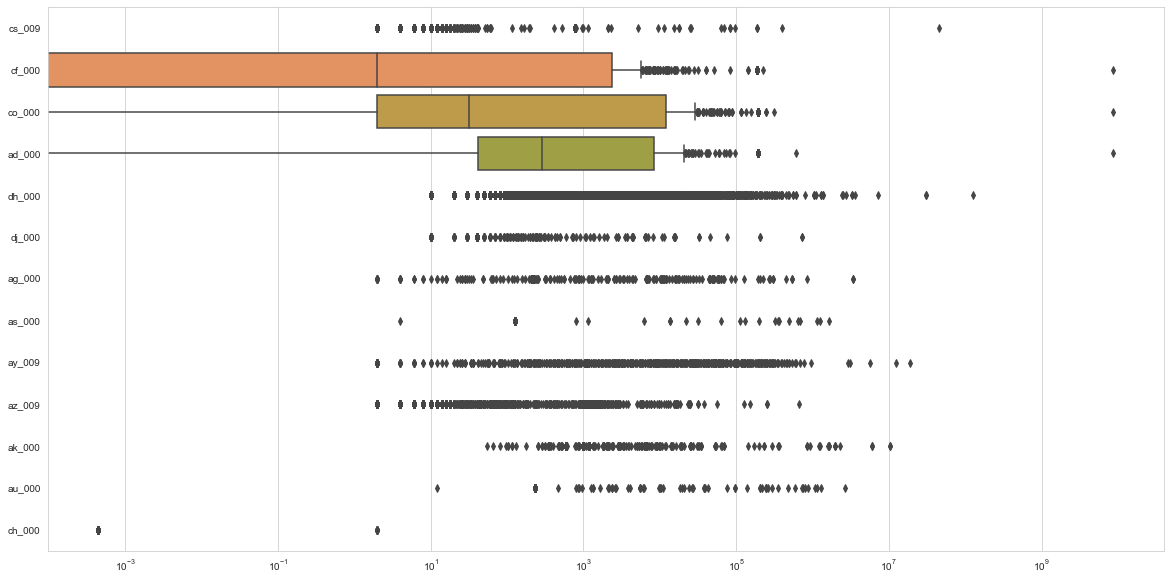

In [50]:
plt.close()
fig, ax = plt.subplots(figsize=(15,10))
boxplot = sns.boxplot(ax= ax, data=aps_train_X[selected_features], orient='h')
boxplot.set(xscale="log")
plt.show()

### __v. Determine the number of positive and negative data. Is this data set imbalanced?__

In [51]:
print(' Positive and Negatives in Training data')
aps_train_Y.value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

In [52]:
print('Positive and Negatives in Testing data')
aps_test_Y.value_counts()

neg    15625
pos      375
Name: class, dtype: int64

#### __Yes, both train and test datasets are heavily imbalanced.__

### __(c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forest and compare it to the test error.__

In [53]:
def roc_auc(data_X, data_Y, model, data_type):
    prob = model.predict_proba(data_X)
    
    fpr, tpr, thresholds = roc_curve(data_Y, prob[:, 1], pos_label='pos')
    roc_auc = auc(fpr, tpr)

    plt.close()
    plt.figure(figsize=(10,6))
    plt.plot(fpr, tpr, 'b', label="Area Under Curve(AUC): {}".format(roc_auc))
    plt.plot([0,1], [0,1], 'k--')

    plt.title('ROC Curve for {} data'.format(data_type))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend()
    plt.grid()
    plt.show()

In [54]:
def metrics(data_Y, predict):
    matrix = confusion_matrix(data_Y, predict)
    accuracy = accuracy_score(data_Y, predict)
    
    return matrix, accuracy

In [55]:
# Random forest model which is imbalanced
RandomForest_model = RandomForestClassifier(max_depth=5, random_state=7, n_jobs = -1, oob_score=True)
RandomForest_model.fit(aps_train_X, aps_train_Y)

predict = RandomForest_model.predict(aps_train_X)

matrix, accuracy = metrics(aps_train_Y, predict)
print('Confusion Matrix of Train Data - Imbalanced Data')
print(matrix)
print('Train Classification Accuracy : ', accuracy)

Confusion Matrix of Train Data - Imbalanced Data
[[58969    31]
 [  451   549]]
Train Classification Accuracy :  0.9919666666666667


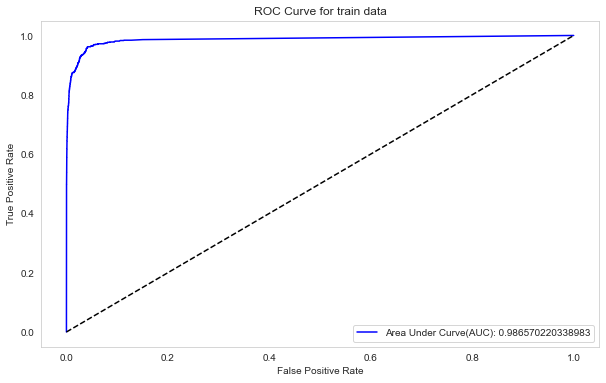

In [56]:
roc_auc(aps_train_X, aps_train_Y, RandomForest_model, 'train')

In [57]:
# Random forest model which is imbalanced
predict = RandomForest_model.predict(aps_test_X)

matrix, accuracy = metrics(aps_test_Y, predict)
print('Confusion Matrix of Test Data - Imbalanced Data')
print(matrix)
print('Test Classification Accuracy : ', accuracy)

Confusion Matrix of Test Data - Imbalanced Data
[[15611    14]
 [  182   193]]
Test Classification Accuracy :  0.98775


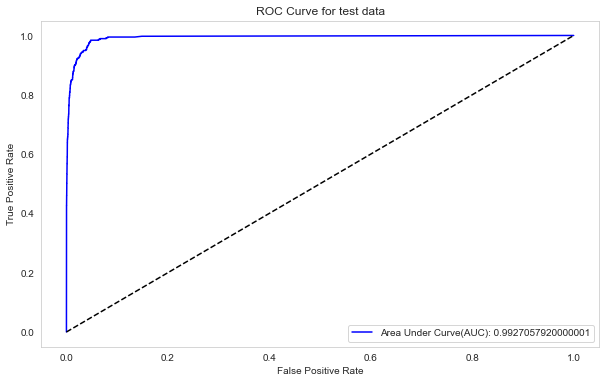

In [58]:
roc_auc(aps_test_X, aps_test_Y, RandomForest_model, 'test')

In [59]:
print('Out of Bag error estimate for our random forest model : ', 1-RandomForest_model.oob_score_)
print('Test Error : ', 1 - accuracy)

Out of Bag error estimate for our random forest model :  0.009183333333333321
Test Error :  0.012249999999999983


### (d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 2c. Compare the results with those of 2c.

In [60]:
# Random forest model which is balanced
RandomForest_model_balanced = RandomForestClassifier(max_depth=5, random_state=7, n_jobs = -1, 
                                            oob_score=True, class_weight='balanced')
RandomForest_model_balanced.fit(aps_train_X, aps_train_Y)

predict = RandomForest_model_balanced.predict(aps_train_X)

matrix, accuracy = metrics(aps_train_Y, predict)
print('Confusion Matrix of Train Data - Imbalanced Data')
print(matrix)
print('Train Classification Accuracy : ', accuracy)

Confusion Matrix of Train Data - Imbalanced Data
[[56619  2381]
 [   29   971]]
Train Classification Accuracy :  0.9598333333333333


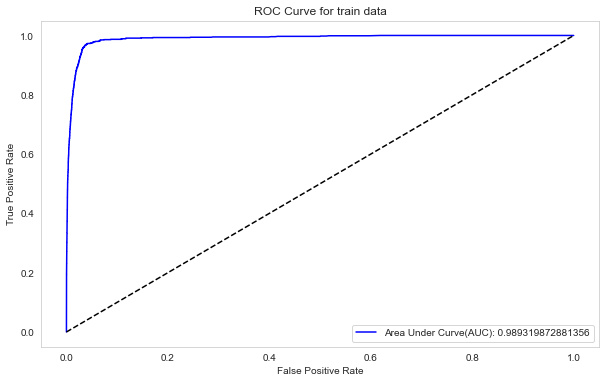

In [61]:
roc_auc(aps_train_X, aps_train_Y, RandomForest_model_balanced, 'train')

In [62]:
# Random forest model which is balanced
predict = RandomForest_model_balanced.predict(aps_test_X)

matrix, accuracy = metrics(aps_test_Y, predict)
print('Confusion Matrix of Test Data - Imbalanced Data')
print(matrix)
print('Test Classification Accuracy : ', accuracy)

Confusion Matrix of Test Data - Imbalanced Data
[[15021   604]
 [   14   361]]
Test Classification Accuracy :  0.961375


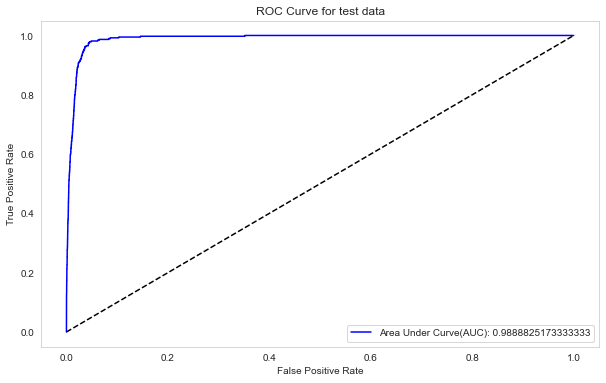

In [63]:
roc_auc(aps_test_X, aps_test_Y, RandomForest_model_balanced, 'test')

In [64]:
print('Out of Bag error estimate for our random forest model : ', 1-RandomForest_model_balanced.oob_score_)
print('Test Error : ', 1 - accuracy)

Out of Bag error estimate for our random forest model :  0.04146666666666665
Test Error :  0.03862500000000002


Even the errors slightly incresed, we developed a model with more balanced data than 2c.

# e)  XGBoost and Model Trees


### In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used to determine the split of that node (i.e. instead of using Xj > s as the decision rule, one has 􏰀j βjXj > s. as the decision rule). Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node.

### One of the methods that can be used at each node is Logistic Regression. Because the number of variables is large in this problem, one can use L1-penalized logistic regression at each node. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation. Train the model for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

## L1 penalized Logistic Regression with xgboost

In [65]:
#alphas = [5.0 ** i for i in range(-5, 5)]
alphas={'harsha':[0.00032, 0.0016, 0.008, 0.04, 0.2, 1, 5, 25, 125, 625]}

k_fold_cv = KFold(n_splits=7)

xgb_model = xgb.XGBClassifier(objective="binary:logistic",n_estimators=5,verbosity=0)

xgb_model.fit(aps_train_X, aps_train_Y,eval_set=[(aps_train_X, aps_train_Y)],eval_metric='logloss')

cv_model=GridSearchCV(xgb_model,alphas,cv=k_fold_cv, n_jobs=1, scoring='roc_auc',verbose=0)

cv_model.fit(aps_train_X,aps_train_Y)

[0]	validation_0-logloss:0.600876
[1]	validation_0-logloss:0.526394
[2]	validation_0-logloss:0.463522
[3]	validation_0-logloss:0.410472
[4]	validation_0-logloss:0.365216


GridSearchCV(cv=KFold(n_splits=7, random_state=None, shuffle=False),
             estimator=XGBClassifier(n_estimators=5, verbosity=0), n_jobs=1,
             param_grid={'harsha': [0.00032, 0.0016, 0.008, 0.04, 0.2, 1, 5, 25,
                                    125, 625]},
             scoring='roc_auc')

In [66]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic',n_estimators=5,verbosity=0,random_state=0,reg_alpha=cv_model.best_params_['harsha'])

xgb_model.fit(aps_train_X, aps_train_Y,eval_set=[(aps_train_X, aps_train_Y)],eval_metric='logloss')

cv_model.best_score_

[0]	validation_0-logloss:0.600876
[1]	validation_0-logloss:0.526394
[2]	validation_0-logloss:0.463522
[3]	validation_0-logloss:0.410472
[4]	validation_0-logloss:0.365216


0.9368435075802182

In [67]:
predict = xgb_model.predict(aps_train_X)

matrix, accuracy = metrics(aps_train_Y, predict)
print('Confusion Matrix of Train Data - Imbalanced Data')

print(matrix)
print('Train Accuracy : ', accuracy)

print('Train Error using XGBoost : ', 1-accuracy)

Confusion Matrix of Train Data - Imbalanced Data
[[58903    97]
 [  494   506]]
Train Accuracy :  0.99015
Train Error using XGBoost :  0.009850000000000025


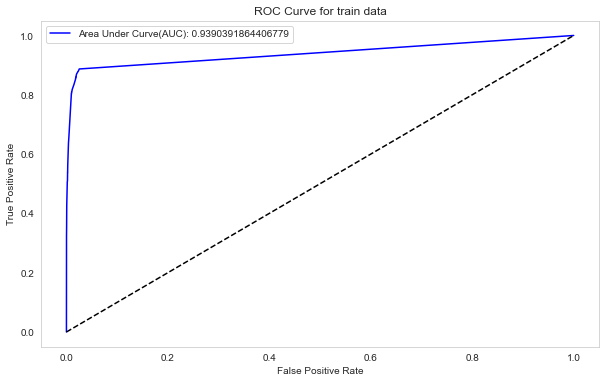

In [68]:
roc_auc(aps_train_X, aps_train_Y, xgb_model, 'train')

In [69]:
predict = xgb_model.predict(aps_test_X)

matrix, accuracy = metrics(aps_test_Y, predict)
print('Confusion Matrix of Test Data - Imbalanced Data')

print(matrix)
print('Test Classification Accuracy : ', accuracy)

print('Test Error : ', 1 - accuracy)

Confusion Matrix of Test Data - Imbalanced Data
[[15600    25]
 [  200   175]]
Test Classification Accuracy :  0.9859375
Test Error :  0.014062499999999978


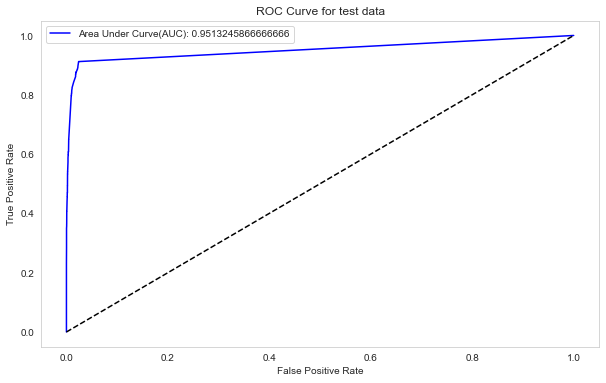

In [70]:
roc_auc(aps_test_X, aps_test_Y, xgb_model, 'test')

## f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance.4 Train XGBosst with L1-penalized lo- gistic regression at each node using the pre-processed data and repeat 2e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE case.

In [71]:
#Smote instance
smote = SMOTE(random_state=11)

#pipeline with xgboost L1 penalized logistic regression
pipeline = imbpipeline(steps = [['smote', smote],
                                ['scaler', MinMaxScaler()],
                                ['classifier', xgb.XGBClassifier(objective="binary:logistic",n_estimators=5,verbosity=0)]])

#Stratified k fold with 5 splits
stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)
                                
#pipeline.fit()
    
#Alphas
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
                                
#Gridsearch Cross Validation
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

# Fit the model 
grid_search.fit(aps_train_X, aps_train_Y)

# Best score
cv_score = grid_search.best_score_
                                
#Test score
test_score = grid_search.score(aps_test_X, aps_test_Y)
                                

print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.9738549152542373
Test score: 0.9850838186666666


In [72]:
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.9738549152542373
Test score: 0.9850838186666666


In [73]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic',n_estimators=5,verbosity=0,random_state=0,reg_alpha=grid_search.best_params_['classifier__C'])

xgb_model.fit(aps_train_X, aps_train_Y,eval_set=[(aps_train_X, aps_train_Y)],eval_metric='logloss')



[0]	validation_0-logloss:0.600876
[1]	validation_0-logloss:0.526395
[2]	validation_0-logloss:0.463522
[3]	validation_0-logloss:0.410472
[4]	validation_0-logloss:0.365216


XGBClassifier(n_estimators=5, reg_alpha=0.001, verbosity=0)

In [74]:
predict = xgb_model.predict(aps_train_X)

matrix, accuracy = metrics(aps_train_Y, predict)
print('Confusion Matrix of Train Data - Imbalanced Data')
print(matrix)
print('Train Classification Accuracy : ', accuracy)


print('Train Error using XGBoost : ', 1-accuracy)

Confusion Matrix of Train Data - Imbalanced Data
[[58903    97]
 [  494   506]]
Train Classification Accuracy :  0.99015
Train Error using XGBoost :  0.009850000000000025


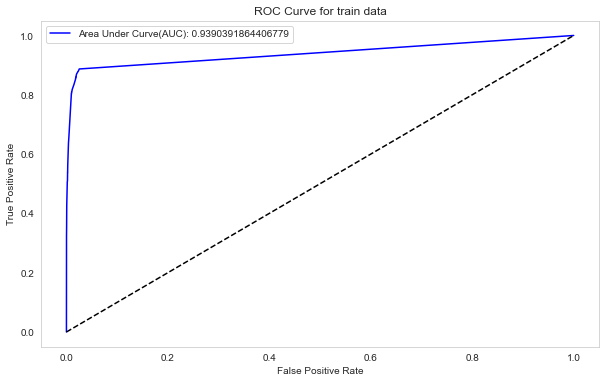

In [75]:
roc_auc(aps_train_X, aps_train_Y, xgb_model, 'train')

In [76]:
predict = xgb_model.predict(aps_test_X)

matrix, accuracy = metrics(aps_test_Y, predict)
print('Confusion Matrix of Test Data - Imbalanced Data')
print(matrix)

print('Test Classification Accuracy : ', accuracy)

print('Test Error : ', 1 - accuracy)

Confusion Matrix of Test Data - Imbalanced Data
[[15600    25]
 [  200   175]]
Test Classification Accuracy :  0.9859375
Test Error :  0.014062499999999978


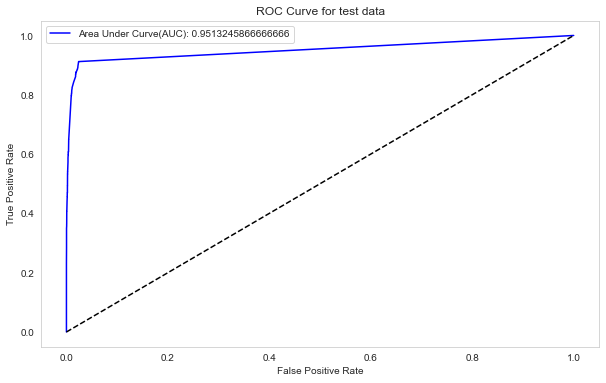

In [77]:
roc_auc(aps_test_X, aps_test_Y, xgb_model, 'test')

# 2. ISLR 6.6.3

(a) Steadily decrease because, As s increases the constraint on beta decreases and the RSS reduces until we reach the OLS value. Thus, the traning RSS will steadily decrease.
 
(b) Decrease initially, and then eventually start increasing when it reaches maximum point. Along with the growth of $s$, the values of estimated coefficients will gradually go non-zero. That means the the number of predictors increases and the model becomes more flexible.

(c) Steadily increase because $\beta$'s are almost all zero at the beginning. There is almost no variance at the beginning stage. After the model becoming flexible, the variance will increase.

(d) Steadily decrease because bias is opposite to variance according to bias-variance trade-off.

(e) Remains constant because the model is independent of irreducible error.

# 3. ISLR 6.6.5

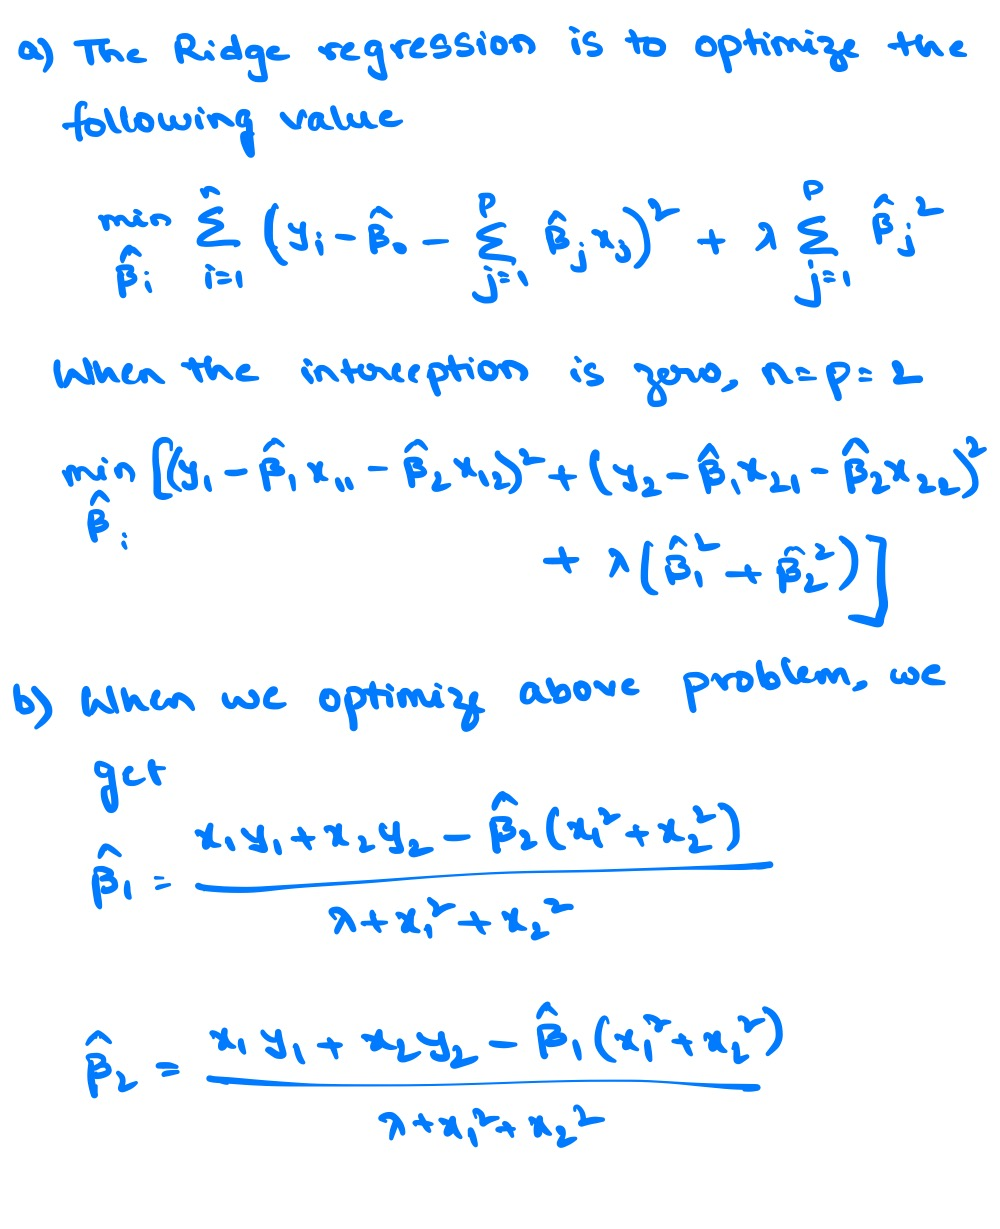

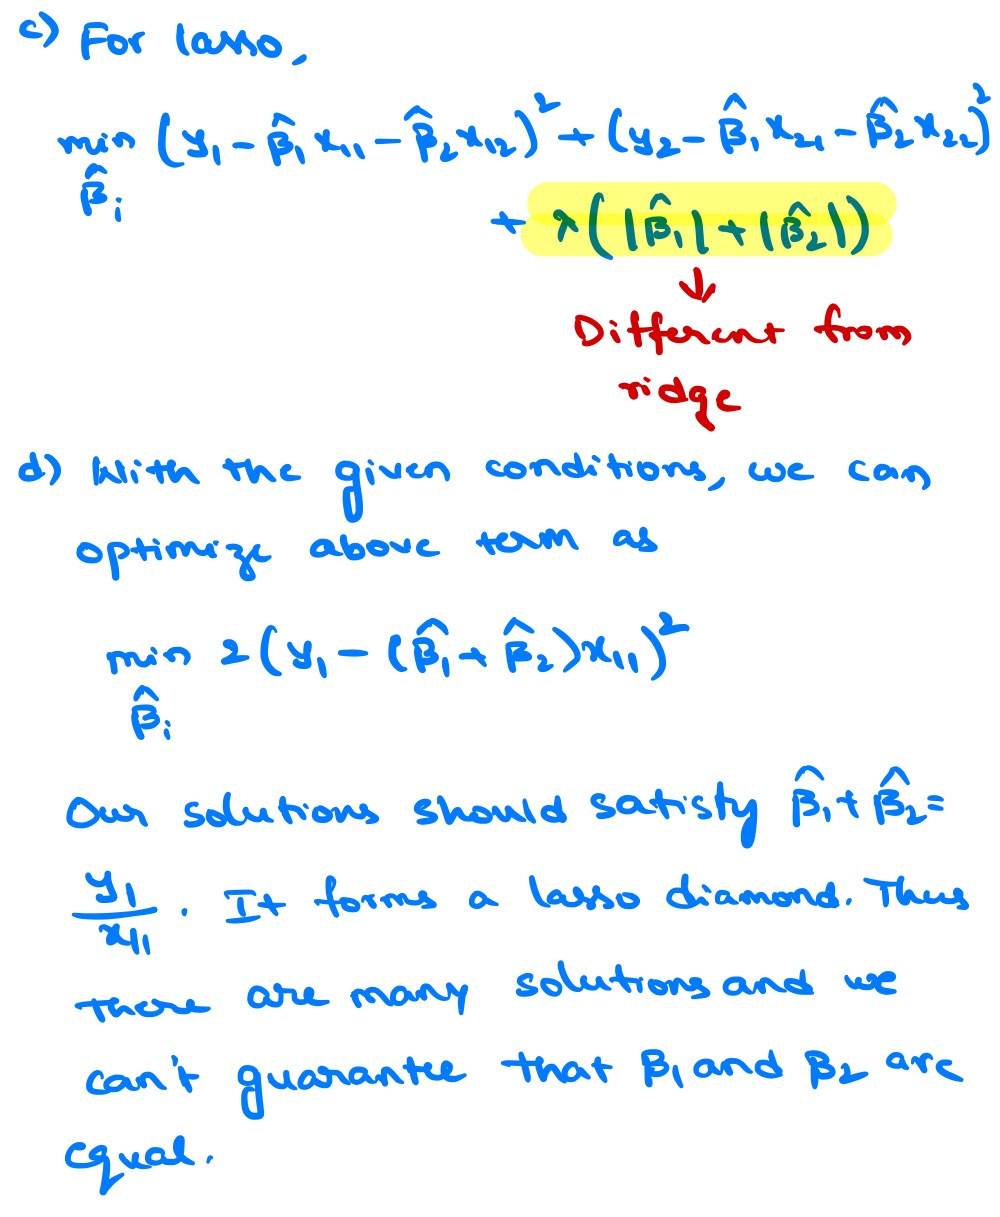

# 4. ISLR 8.4.5

**Majority Voting**
- Red samples has a larger number than green samples. Thus, X is classified as red.

**Average probability**
- P(Class is Red | X) is 4.5/10 = 0.45. Thus, X is classified as green

# 5. ISLR 9.7.3

In [78]:
sample_dict = {'X1' : [3, 2, 4, 1, 2, 4, 4], 
           'X2' : [4, 2, 4, 4, 1, 3, 1], 
           'Y' : ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue']}
sample_df = pd.DataFrame.from_dict(sample_dict)

In [79]:
# create svm model
clf = SVC(kernel='linear', C=10000)
clf.fit(sample_df.iloc[:, :-1], sample_df.iloc[:, -1])

SVC(C=10000, kernel='linear')

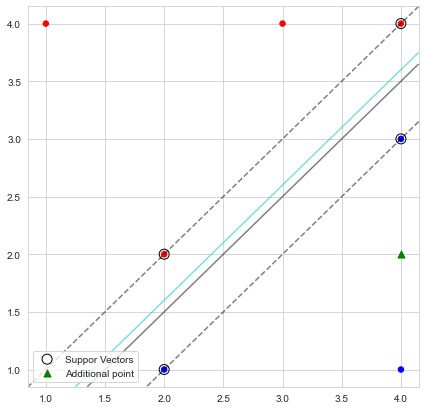

[0.99970703] [[-1.99941406  1.99941406]]


In [80]:
# plot graph
fig, ax = plt.subplots(figsize=(7, 7))

# scatter plot of sample points
ax.scatter(sample_df.iloc[:, 0], sample_df.iloc[:, 1], 
           c=sample_df.iloc[:, -1], s=30, 
           cmap=plt.cm.Paired)

# create a grid
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# hyperplane
lines1 = ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'], label="Decision Boundary")

# support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k', label="Suppor Vectors")

# a hyperplane that is not optimal
lines2 = ax.contour(XX, YY, Z - 0.2, colors='c', levels=[0], alpha=0.5,
           linestyles=['-'])

# point make the data NOT linear-separable
ax.scatter([4.0], [2.0], color='g', marker='^', s=50, label="Additional point")

ax.legend()
plt.show()

print(clf.intercept_, clf.coef_)

(b) The solid black lines is the hyperplane.

(c) We can see, the parameters are approximately:

$
\beta_0 = 1 \\ \beta_1 = -2 \\ \beta_2 = 2 \\
\beta_0 + \beta_1 X_1 + \beta_2 X_2 > 0 \Rightarrow red, else \Rightarrow blue
$

(d) The dash lines indicates the maximal margin

(e) The circeled ones are support vectors.

(f) The seventh point is far away from the maximal margin hyperplane. If it is on the edge of decision boundary, it will have effects but it does not.

(g) The solid cyan line.

(h) The new point marked as green triangle. This make the points form an XOR pattern which is not linear-separable.

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer.fit_transform
    
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        
https://xgboost.readthedocs.io/en/stable/parameter.html
        
https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#imblearn.over_sampling.SMOTE

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html